In [1]:
using StaticArrays

In [2]:
using Plots, LinearAlgebra

In [3]:
import Statistics: mean

In [4]:
using Profile

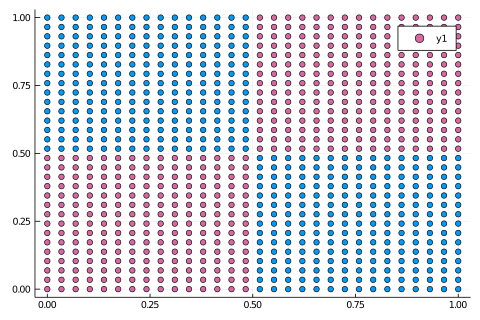

In [5]:
X = collect(hcat(reshape([[x1; x2] for x1 in range(0, stop=1, length=30), x2 in range(0, stop=1, length=30)], 1, :)...)')
Y = [xor(Int(round(x1)),Int(round(x2))) for (x1, x2) in eachrow(X)]
scatter(X[:,1], X[:,2], color=Y, dpi=20)

---

# "Almost" Zero-Allocation Neural Network

In [196]:
module ZeroAllocationNN
import LinearAlgebra: ⋅
export ZANN
mutable struct ZANN
    weights :: Vector{Matrix{Float64}}
    biases :: Vector{Vector{Float64}}
    
    weighted_inputs :: Vector{Vector{Float64}}
    
    function ZANN(layer_dims)
        weights = []
        biases = []
        for i = 2:length(layer_dims)
            push!(weights, randn(layer_dims[i], layer_dims[i - 1]))
            push!(biases, randn(layer_dims[i]))
        end
        return new(
            weights,
            biases,
            [Vector{Float64}(undef, 0) for _ in 1:length(layer_dims)]
        )
    end
end

export predict
function predict(nn::ZANN, x :: Vector{Float64})
    a = x # 1 allocation
    for (w, b) in zip(nn.weights, nn.biases)
        a = w * a # 1 allocation
        @. a = sigma(a + b)
    end
    return a # 1 allocation
end


sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x)*(1-sigma(x))

export backprop
function backprop(nn::ZANN, x :: Vector{Float64}, y :: Vector{Float64})
    # forward pass, the difference from predict is that we save the activations
    # and the weighted inputs
    a = x
    nn.weighted_inputs = []
    activations :: Vector{Vector{Float64}} = [x]
    
    for (i, (w, b)) in enumerate(zip(nn.weights, nn.biases))
        z = w * a
        @. z += b
        nn.weighted_inputs[i] = z
        a = sigma.(z)
        push!(activations, a)
    end
    
    # backward pass
    nabla_ws :: Vector{Matrix{Float64}} = []
    nabla_bs :: Vector{Vector{Float64}} = []

    # BP1 (Output layer error)
    delta :: Vector{Float64} = (activations[end] - y) .* sigma_prime.(nn.weighted_inputs[end])
    # BP3 (Cost gradient w.r.t Bias)
    push!(nabla_bs, delta)
    # BP4 (Cost gradient w.r.t weights)
    push!(nabla_ws, delta * activations[end-1]')
    
    for (w, z, a) in Iterators.reverse(zip(nn.weights, nn.weighted_inputs[1:end-1], activations[1:end-2]))
        delta = (w'*delta) .* sigma_prime.(z) # BP2 (Previous layer error)
        push!(nabla_bs, delta)
        push!(nabla_ws, delta * a')
    end
    
    return reverse(nabla_ws), reverse(nabla_bs)
end



end

import Main.ZeroAllocationNN

println("Network creation")
@time zann = ZeroAllocationNN.ZANN([2,30,20,1]);
println("Prediction")

@time ZeroAllocationNN.predict(zann, randn(2));
# @code_warntype ZeroAllocationNN.predict(zann, randn(2));
println("Backpropagation")
@time ZeroAllocationNN.backprop(zann, randn(2), randn(1));

Network creation
  0.000031 seconds (19 allocations: 7.297 KiB)
Prediction


  0.000023 seconds (4 allocations: 768 bytes)
Backpropagation


LoadError: BoundsError: attempt to access 0-element Array{Array{Float64,1},1} at index [1]

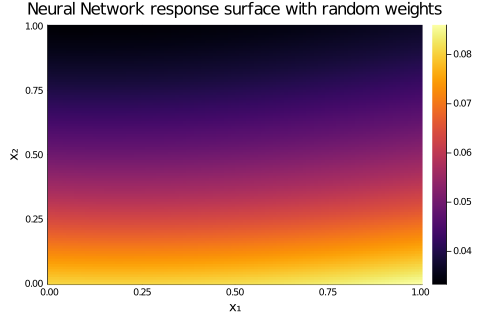

In [183]:
heatmap(
    range(0, stop=1, length=100),
    range(0, stop=1, length=100),
    (x1, x2) -> ZeroAllocationNN.predict(zann, [x1, x2])[1],
    title="Neural Network response surface with random weights",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

In [184]:
@time for epoch in 1:1_000
    for i in 1:length(Y) # For every row instance of the training set
        x = X[i, :]
        y = Y[i]
        nabla_ws, nabla_bs = ZeroAllocationNN.backprop(zann, Vector(x), [float(y)])
        zann.weights -= (0.01 * nabla_ws)
        zann.biases -= (0.01 * nabla_bs)
    end
end

 15.479490 seconds (51.06 M allocations: 19.590 GiB, 19.97% gc time)


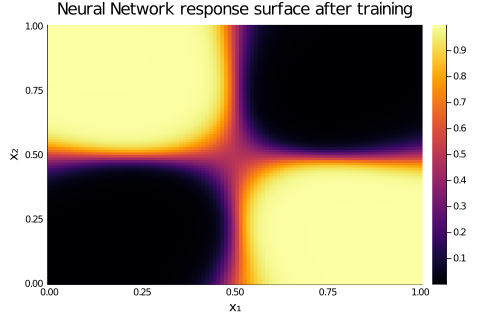

In [185]:
heatmap(
    range(0, stop=1, length=100),
    range(0, stop=1, length=100),
    (x1, x2) -> ZeroAllocationNN.predict(zann, [x1, x2])[1],
    title="Neural Network response surface after training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)